# Look at climate change in MPI

## Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xarray as xr
import warnings
import tqdm
import pathlib
import cmocean
import os

# Import custom modules
import src.utils
from src.XRO import XRO, xcorr

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Functions

In [2]:
def get_zonal_grad(x):
    """
    Function to compute zonal gradient. Ref: Fig 7 in Maher et al, 2023.
    """

    ## outlines for boxes
    ebox_coords = dict(longitude=slice(210, 270), latitude=slice(-5, 5))
    wbox_coords = dict(longitude=slice(120, 180), latitude=slice(-5, 5))

    ## compute box averages
    ebox_avg = src.utils.spatial_avg(x.sel(ebox_coords))
    wbox_avg = src.utils.spatial_avg(x.sel(wbox_coords))

    return ebox_avg - wbox_avg

## Load spatial data

In [3]:
def get_rolling_avg(x, n, dim="time"):
    """Get rolling average over 2n+1 timesteps, and remove NaNs"""

    ## compute rolling average
    x_rolling = x.rolling({dim: 2 * n + 1}, center=True).mean()

    ## remove NaNs
    if n != 0:
        x_rolling = x_rolling.isel({dim: slice(n, -n)})

    return x_rolling


def separate_forced(data, n=0):
    """
    Get forced component of ensemble. 'n' specifies number of years
    to average over when computing "forced" component. I.e., average
    n time over a window size of [t-n, t+n], so total window size
    is 2n + 1.
    Returns:
        - forced: 'externally forced' component of ensemble
        - anom: total minus forced component
    """

    ## compute ensemble mean
    ensemble_mean = data.mean("member")

    ## function to average in time
    rolling_avg = lambda x: x.rolling({"time": 2 * n + 1}, center=True).mean()

    ## group by month, then computing rolling mean over years
    get_rolling_avg_ = lambda x: get_rolling_avg(x, n=n)
    forced = ensemble_mean.groupby("time.month").map(get_rolling_avg_)

    ## make sure time axis is in order
    forced = forced.isel(time=forced.time.argsort().values)

    ## compute anomalies
    anom = data.sel(time=forced.time) - forced

    return forced, anom

In [10]:
## specify sliding window size for climatology
n_years = 3

## Load EOF data
eofs_fp = pathlib.Path(DATA_FP, "mpi", "eofs")
eofs = src.utils.load_eofs(eofs_fp / "ts.nc")

## for convenience, put PC data into single dataset
pc_data = eofs.scores().rename("sst")

## get forced/anomalous component
forced, anom = separate_forced(pc_data, n=n_years)

## Warming pattern over time

In [11]:
## get rolling avg
forced_rolling = get_rolling_avg(forced, n=1)

## get NDJ season
month = forced_rolling.time.dt.month
forced_ndj = forced_rolling.isel(time=(month == 12))

# ## reconstruct equatorial average
eq_avg = lambda x: x.sel(latitude=slice(-2, 2)).mean("latitude")
kwargs = dict(scores=forced_ndj, components=eofs.components(), fn=eq_avg)
forced_ndj_recon = src.utils.reconstruct_fn(**kwargs).sel(longitude=slice(125, 280))

## subtract leading 30-year mean
forced_ndj_recon -= forced_ndj_recon.isel(time=slice(None, 30)).mean("time")

Make plot

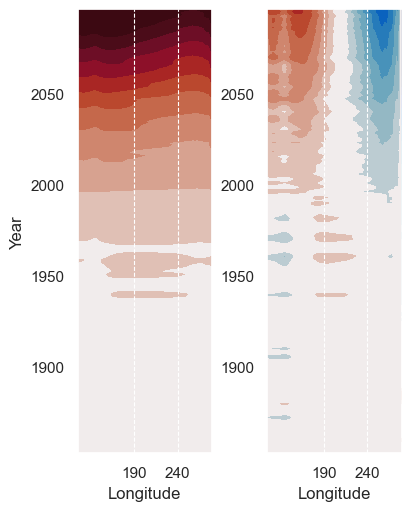

In [12]:
## setup plot
fig, axs = plt.subplots(1, 2, figsize=(4, 5), layout="constrained")

## plot mean
kwargs = dict(levels=src.utils.make_cb_range(3, 0.3), cmap="cmo.balance", extend="both")
plot_data = axs[0].contourf(
    forced_ndj_recon.longitude,
    forced_ndj_recon.time.dt.year,
    forced_ndj_recon.T,
    **kwargs
)

## plot diff from mean
kwargs = dict(
    levels=src.utils.make_cb_range(0.5, 0.05), cmap="cmo.balance", extend="both"
)
plot_data = axs[1].contourf(
    forced_ndj_recon.longitude,
    forced_ndj_recon.time.dt.year,
    (forced_ndj_recon - forced_ndj_recon.mean("longitude")).T,
    **kwargs
)

## label
axs[0].set_ylabel("Year")
kwargs = dict(ls="--", c="w", lw=0.8)
for ax in axs:
    ax.set_xlabel("Longitude")
    ax.set_xticks([190, 240])
    ax.axvline(190, **kwargs)
    ax.axvline(240, **kwargs)

plt.show()

## Change in zonal gradient

### Compute zonal gradient

In [13]:
## get subset of data to look at
anom_ = anom.sel(time=slice("1979", "2024"))

## compute zonal gradient at every time step
zonal_grad = src.utils.reconstruct_fn(eofs.components(), anom_, fn=get_zonal_grad)

## get monthly avg
zonal_grad_by_month = zonal_grad.groupby("time.month").mean()

### Look at forced change

In [14]:
## compute zonal gradient
zonal_grad_forced = src.utils.reconstruct_fn(
    eofs.components(), forced, fn=get_zonal_grad
)

## reshape from time -> (month, year)
reshape = lambda x: x.reshape(12, -1, order="F")
zonal_grad_forced_by_month = reshape(zonal_grad_forced.values)

## subtract clim
clim = zonal_grad_forced_by_month[:, :30].mean(1, keepdims=True)
zonal_grad_change = zonal_grad_forced_by_month - clim

## get month, year dims
month = np.unique(forced.time.dt.month.values)
year = np.unique(forced.time.dt.year)

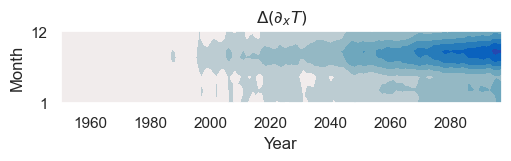

In [15]:
## setup plot
fig, ax = plt.subplots(figsize=(5, 1.5), layout="constrained")

## plot data
kwargs = dict(levels=src.utils.make_cb_range(1, 0.1), cmap="cmo.balance")
plot_data = ax.contourf(year, month, zonal_grad_change, **kwargs)

## label
ax.set_xlabel("Year")
ax.set_ylabel("Month")
ax.set_yticks([1, 12])
ax.set_title(r"$\Delta \left(\partial_x T\right)$")
ax.set_xlim([1950, None])

plt.show()

## Look at mean state-dependence

### Compare Bjerknes growth rate to zonal gradient

#### Load $T,h$ data

In [17]:
## MPI data
mpi_load_fp = pathlib.Path(DATA_FP, "mpi_Th", "Th.nc")
Th = xr.open_dataset(mpi_load_fp)

#### Fit RO to $T,h$ data

In [18]:
## get subset of data
Th_sub = Th.sel(time=slice("1979", "2024"))

## initialize model
model = XRO(ncycle=12, ac_order=3, is_forward=True)

## fit to individual ensemble members
kwargs = dict(model=model, T_var="T_3", h_var="h_w", verbose=True)
_, fits = src.utils.get_RO_ensemble(Th_sub, **kwargs)

## extract parameters
params = model.get_RO_parameters(fits)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.12it/s]


#### Look at intra-ensemble spread
$\partial_x T$ vs. BJ index  
Compare to Maher et al (2023)

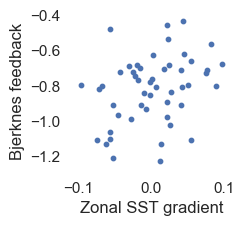

In [19]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(zonal_grad_by_month.mean("month"), params["R"].mean("cycle"), s=10)
# ax.scatter(zonal_grad_by_month.sel(month=7), params["R"].sel(cycle=7), s=10)
ax.set_xlabel("Zonal SST gradient")
ax.set_ylabel("Bjerknes feedback")
plt.show()